# Filter Zero Outter Analysis

In [30]:

import tarfile
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from experiments.grid_size.experiment import GridSizeExperiment
from commands.datastore import Datastore
from functools import reduce
from parse import parse
import matplotlib.ticker as ticker

sns.set_theme(context="paper", style="whitegrid", rc={"text.usetex" : False})
sns.set_palette("deep")
sns.color_palette("deep")
sns.set_theme(context="paper", font="qhv", style="ticks", rc={
    "text.usetex" : True
})

data_store = Datastore().derive("single_filter_zero_outter")
figures = data_store / "figures"
figures.mkdir(exist_ok=True, parents=True)

In [31]:
import os
from pathlib import Path


def create_df(path: str = data_store, tar_files = ["single_filter_zero_outter.tar"], best_solution=False) -> pd.DataFrame:
    path = Path(path)
    experiment_runs = set()
    for file in [path / tar for tar in tar_files]:
        with tarfile.open(file, "r:*") as tar:
            for f in tar.getnames():
                result = parse("{layer_name}_{i}_{j}/train_statistics/fitness/{file}", f)
                result = result or parse("{layer_name}_{i}_{j}_zero/train_statistics/fitness/{file}", f)
                if result is not None:
                    experiment = "{layer_name}_{i}_{j}".format(**result.named)
                    csv = pd.read_csv(tar.extractfile(f))
                    csv["Experiment"] = experiment
                    csv["zero"] = "zero" in f
                    occurence_string = experiment + "/" + result["file"]
                    
                    if occurence_string in experiment_runs:
                        csv["run"] = csv["run"] + 30
                    
                    experiment_runs.add(occurence_string)
                    
                    if best_solution:
                        yield csv.tail(n=1)
                    else:
                        yield csv
                else:
                    print(f"ignoring {f}")

def load_dfs(path: str = data_store, tar_files = ["single_filter_zero_outter.tar"], best_solution=False):
    df = pd.concat([df for df in create_df(path, tar_files, best_solution=best_solution)], ignore_index=True)
    df.drop(columns="depth", inplace=True, errors="ignore")
    df.drop_duplicates(subset=["generation"], inplace=True)
    df.columns = df.columns.str.title().str.replace("_", " ")
    return df

def get_best_solutions(df):
    best_solutions = []
    chromosomes_df: pd.DataFrame = df.dropna().sort_values(by=["Error", "Energy", "Delay", "Gate Count"], ascending=True)
    
    groups = chromosomes_df.groupby(by=["Experiment", "Run"])
    best_solutions = groups.apply(pd.DataFrame.head, n=1)
    return best_solutions  

fitness_columns = ["Error", "Energy", "Area", "Delay", "Gate Count"]
quantized_columns = ["Error", "Quantized Energy", "Quantized Delay"]

In [ ]:
df = load_dfs()
df

ignoring conv1_1_0
ignoring conv1_1_0/cgp_configs
ignoring conv1_1_0/cgp_configs/cgp.1.config
ignoring conv1_1_0/cgp_configs/cgp.10.config
ignoring conv1_1_0/cgp_configs/cgp.11.config
ignoring conv1_1_0/cgp_configs/cgp.12.config
ignoring conv1_1_0/cgp_configs/cgp.13.config
ignoring conv1_1_0/cgp_configs/cgp.14.config
ignoring conv1_1_0/cgp_configs/cgp.15.config
ignoring conv1_1_0/cgp_configs/cgp.16.config
ignoring conv1_1_0/cgp_configs/cgp.17.config
ignoring conv1_1_0/cgp_configs/cgp.18.config
ignoring conv1_1_0/cgp_configs/cgp.19.config
ignoring conv1_1_0/cgp_configs/cgp.2.config
ignoring conv1_1_0/cgp_configs/cgp.20.config
ignoring conv1_1_0/cgp_configs/cgp.21.config
ignoring conv1_1_0/cgp_configs/cgp.22.config
ignoring conv1_1_0/cgp_configs/cgp.23.config
ignoring conv1_1_0/cgp_configs/cgp.24.config
ignoring conv1_1_0/cgp_configs/cgp.25.config
ignoring conv1_1_0/cgp_configs/cgp.26.config
ignoring conv1_1_0/cgp_configs/cgp.27.config
ignoring conv1_1_0/cgp_configs/cgp.28.config
ignorin

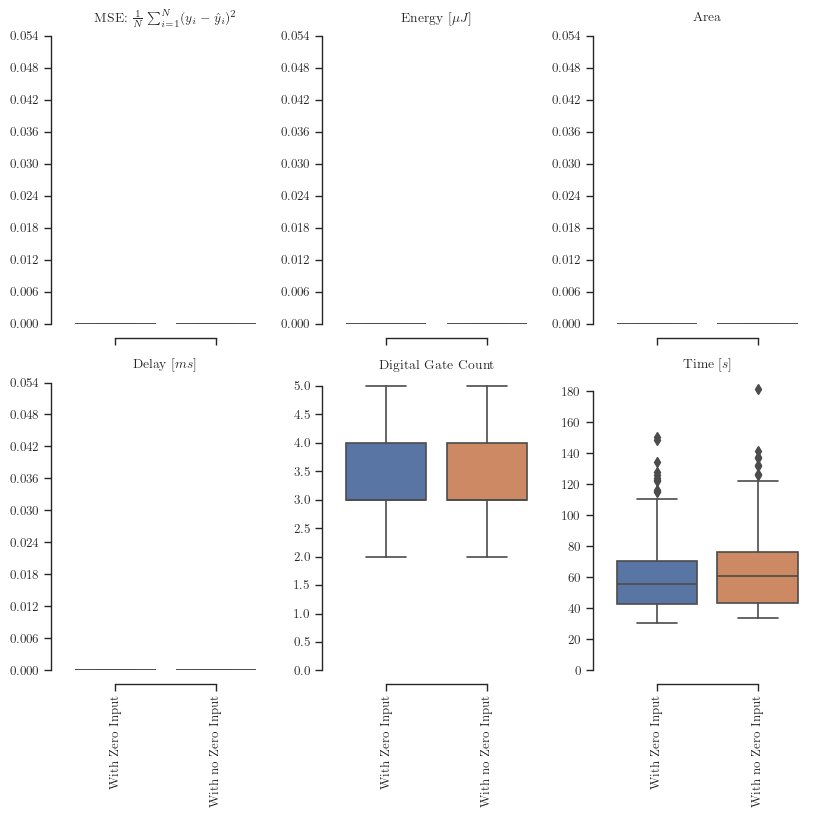

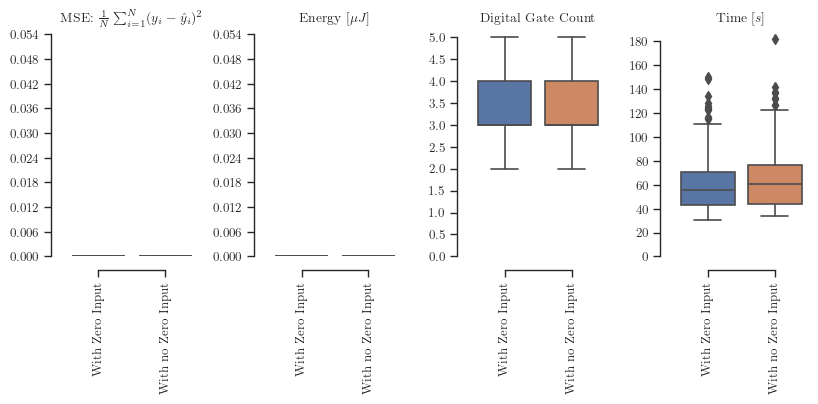

In [33]:
order=[True, False]
def load_df(tar_files = ["single_filter_zero_outter.tar"]):
    solutions_df = load_dfs(tar_files=tar_files, best_solution=True)
    solutions_df["Error"] = solutions_df["Error"] / 16
    return solutions_df

titles = {
    "Error": r"MSE: $\frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2$",
    "Energy": "Energy [$\mu J$]",
    "Area": "Area",
    "Delay": "Delay [$ms$]",
    "Gate Count": "Digital Gate Count",
    "Generation": "Generations",
    "Timestamp": "Time $[s]$"
}

def plot(solutions_df, col, ax, i, sharex_index=True):
    tick_count = solutions_df["Gate Count"].max() + 1
    g = sns.boxplot(data=solutions_df, x="Zero", y=col, order=order, ax=ax)
    g.yaxis.set_major_locator(plt.MaxNLocator(tick_count, min_n_ticks=10, integer=(col=="Gate Count")))
    g.set_ylim(0)
    g.set_title(titles[col])
    g.set_ylabel(None)
    g.set_xlabel(None)
    g.set_xticklabels(["With Zero Input" if flag else "With no Zero Input" for flag in order])
    g.tick_params(axis="x", rotation=90)
    if i < sharex_index:
        g.axes.get_xaxis().set_ticklabels([])
        g.set_xlabel(None)
    return g    

def plot_columns(df, columns, r, c, sharex=True):
    fig, axes = plt.subplots(r, c, figsize=(8.27, 8.27 / 2 * r))
    for col, ax, i in zip(columns, axes.flat, range(r*c)):
        plot(df, col, ax, i, c if sharex else 0)    
    return fig

solutions_df = load_df()
fig_all = plot_columns(solutions_df, fitness_columns + ["Timestamp"], 2, 3)
sns.despine(offset=10, bottom=False, left=False, trim=True, fig=fig_all)
fig_all.tight_layout()
fig_all.savefig(figures / "boxplot.png")
fig_all.savefig(figures / "boxplot.pdf")
fig_all.savefig(figures / "boxplot.svg")

fig_brief = plot_columns(solutions_df, ["Error", "Energy", "Gate Count", "Timestamp"], 1, 4, sharex=False)
sns.despine(offset=10, bottom=False, left=False, trim=True, fig=fig_brief)
fig_brief.tight_layout()
fig_brief.savefig(figures / "boxplot_brief.png")
fig_brief.savefig(figures / "boxplot_brief.pdf")
fig_brief.savefig(figures / "boxplot_brief.svg")